In [23]:
import ast
import networkx as nx
import importlib
import utils
import style
import graph
import copy
importlib.reload(utils)
importlib.reload(style)
importlib.reload(graph)
from utils import ast_to_networkx, node_transform
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from graph import CodeGraph
import xml.dom.minidom
from IPython.display import Image
from style import GeneralStyleParams
import os


In [24]:
images_folder = 'images/'
filename_test_exp = 'code_samples/test-expansion.py'
filename_test_extr = 'code_samples/test-extraction.py'


# How to load python code into ast

In [25]:
with open(filename_test_exp, 'r') as file:
    code = file.read()

tree = ast.parse(code)

# Print the AST
print(ast.dump(tree))

Module(body=[FunctionDef(name='main', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[FunctionDef(name='plus', args=arguments(posonlyargs=[], args=[arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Return(value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load())))], decorator_list=[]), Assign(targets=[Tuple(elts=[Name(id='x', ctx=Store()), Name(id='y', ctx=Store())], ctx=Store())], value=Tuple(elts=[Constant(value=1), Constant(value=2)], ctx=Load())), Assign(targets=[Name(id='res', ctx=Store())], value=Call(func=Name(id='plus', ctx=Load()), args=[Name(id='x', ctx=Load()), Name(id='y', ctx=Load())], keywords=[])), Return(value=Name(id='res', ctx=Load()))], decorator_list=[])], type_ignores=[])


visualizing AST using `networkx` library 

/var/folders/gl/5pxh7s9n19vfr9kxhf29vxyc0000gq/T/ipykernel_19412/2282344183.py:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


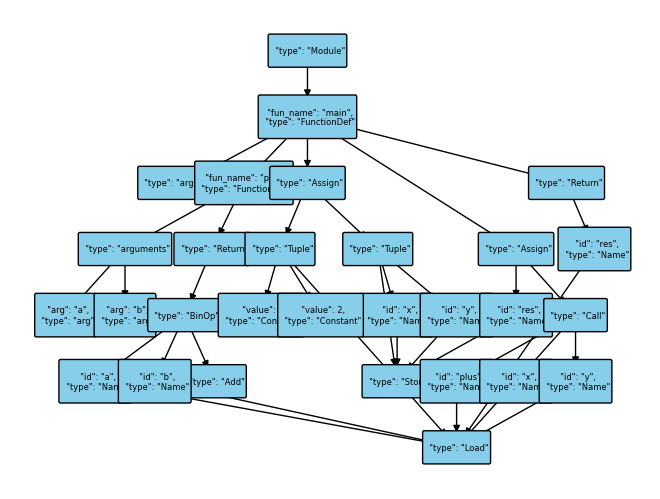

In [26]:
def visualize_ast(filename):
    with open(filename, 'r') as file:
        code = file.read()

    tree = ast.parse(code)
    G = ast_to_networkx(tree)

    node_labels = ({node: node_transform(G, node) for node in G.nodes()})
    pos = graphviz_layout(G, prog="dot")
    pos = {k: (x, 10*y) for k, (x, y) in pos.items()}
    node_size = [(len(node_transform(G, n))+20)*6 for n in G.nodes()]
    nx.draw(G, pos=pos, with_labels=True, node_size=node_size, labels=node_labels, node_shape="s", arrows = True, node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'), font_size=6)

    plt.show()
G = ast_to_networkx(tree)
visualize_ast(filename_test_exp)

# Better visualization for AST

In [27]:
def vis_drawio(g: CodeGraph, output_file_name: str = 'images/temp2', params: GeneralStyleParams = GeneralStyleParams()) -> Image:
    """
    to use this function you need to install drawio and cleate an alias for its command line interface.
    for mac:
        drawio="/Applications/draw.io.app/Contents/MacOS/draw.io"
    """
    mxfile = OurGraphToXML(params).graph_to_xml(g)
    xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
    
    output_file = f'{output_file_name}.png'
    filename    = f'{output_file_name}.drawio'

    with open(filename, 'w') as file:
        file.write(xml_str) 

    bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 2   -o {output_file} {filename}"
    os.system(bashCommand) 

    return Image(output_file)  

# Expanding a function call

def main():

    def minus_2(a, b):
        s = a - b
        return 2 * s
    x, y = 1, 2
    res = minus_2(x, y)
    return res

images/test-expansion-after.drawio -> images/test-expansion-after.png


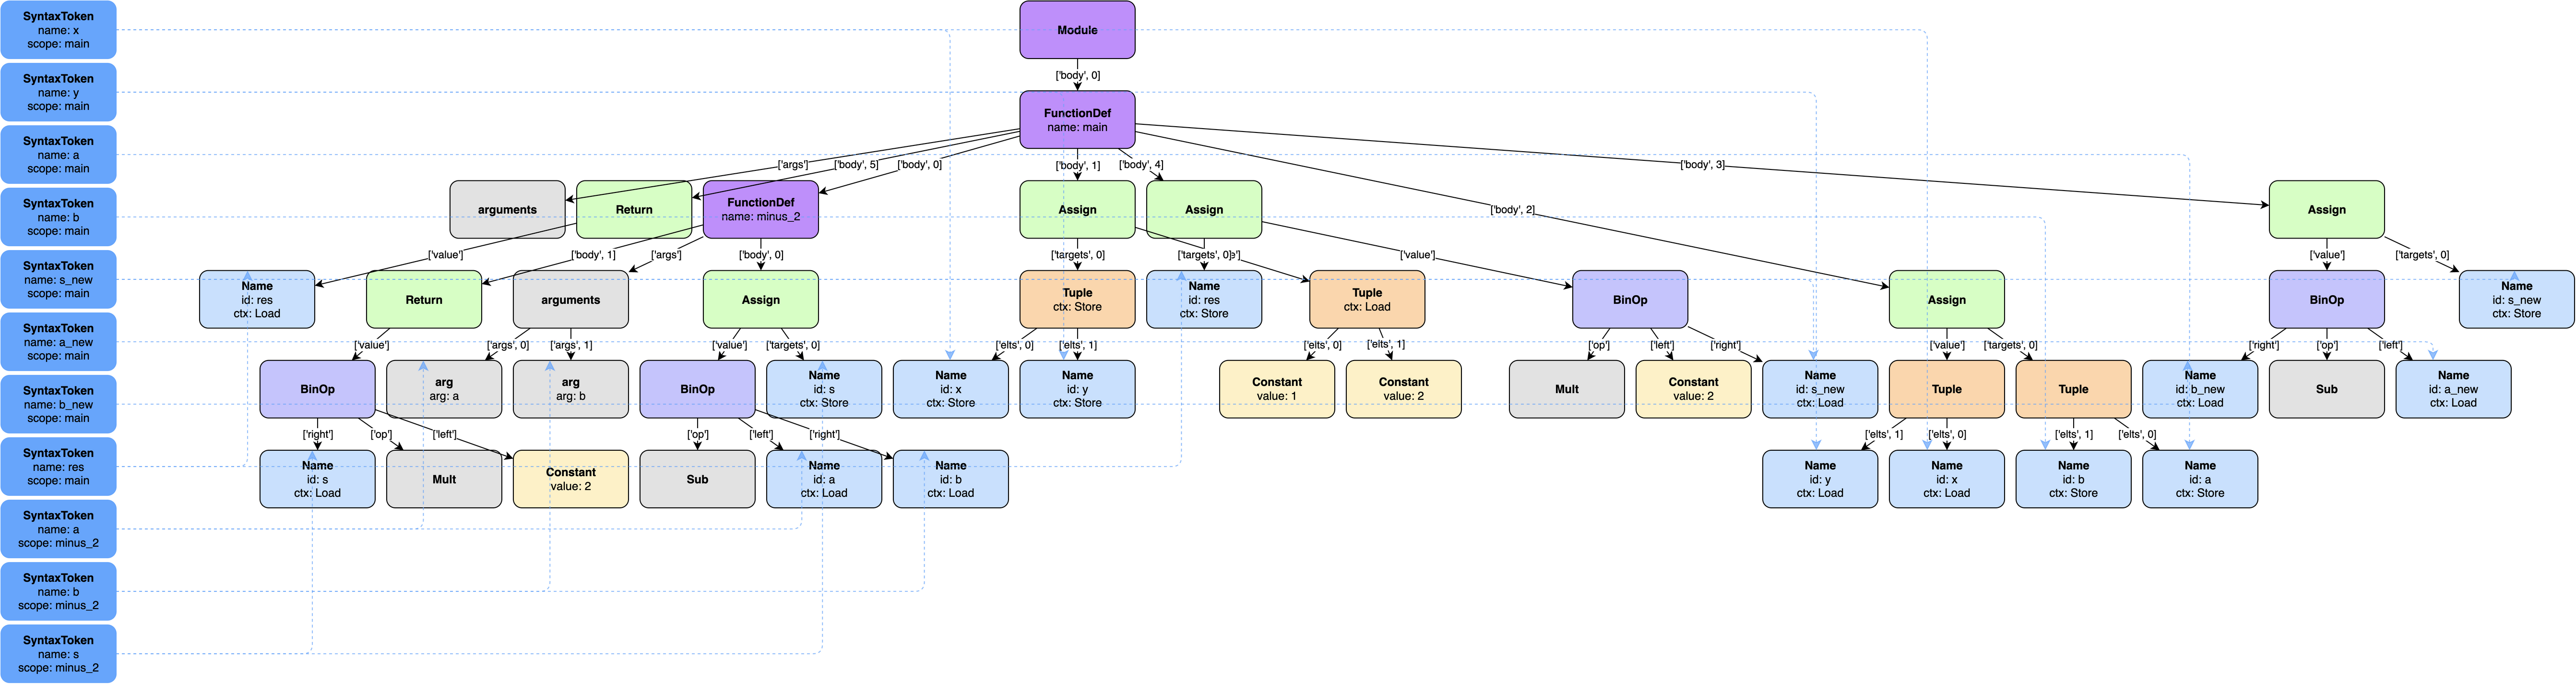

In [72]:
import transforms
importlib.reload(transforms)
importlib.reload(style)
importlib.reload(graph)
from graph import CodeGraph
from style import OurGraphToXML
from transforms import expand_function

params = GeneralStyleParams(y_scaling=1.3)
G = CodeGraph.from_file(filename_test_exp)

G_new = G.copy()

for node_id, node in G_new.ast_nodes.items():
    if isinstance(node, ast.Call):
        break

G_new = expand_function(G_new, node_id)
print(G.to_source())
vis_drawio(G_new, 'images/test-expansion-after', params)



def main():
    y = 2
    x = 2
    z = x + y
    return z

images/test-extraction-before.drawio -> images/test-extraction-before.png


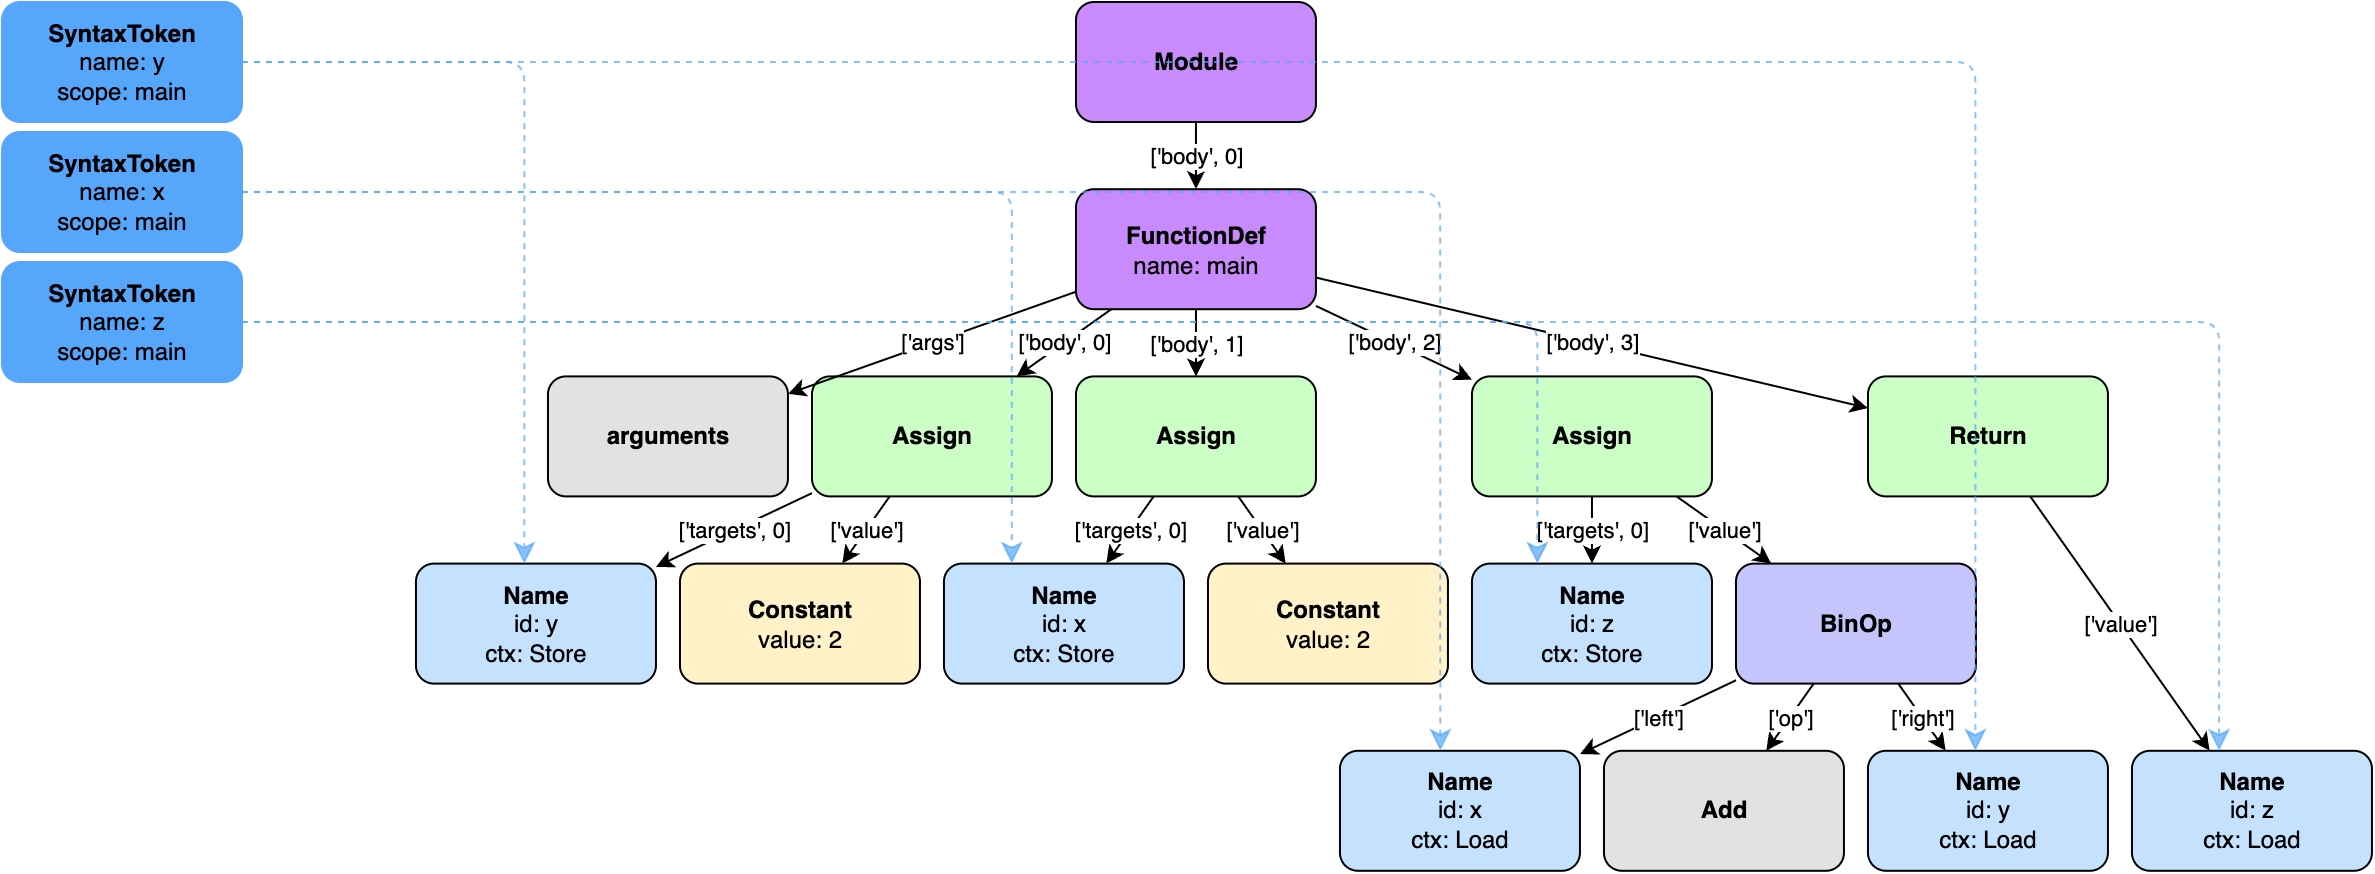

In [29]:
import transforms
importlib.reload(transforms)
from transforms import extract_function

G = CodeGraph.from_file(filename_test_extr)
print(G.to_source())
vis_drawio(G, 'images/test-extraction-before', params)

_____________
def main():

    def minus_2(a, b):
        s = a - b
        return 2 * s
    x, y = 1, 2
    a, b = x, y
    s_new = a_new - b_new
    res = 2 * s_new
    return res

images/test-expansion-after.drawio -> images/test-expansion-after.png


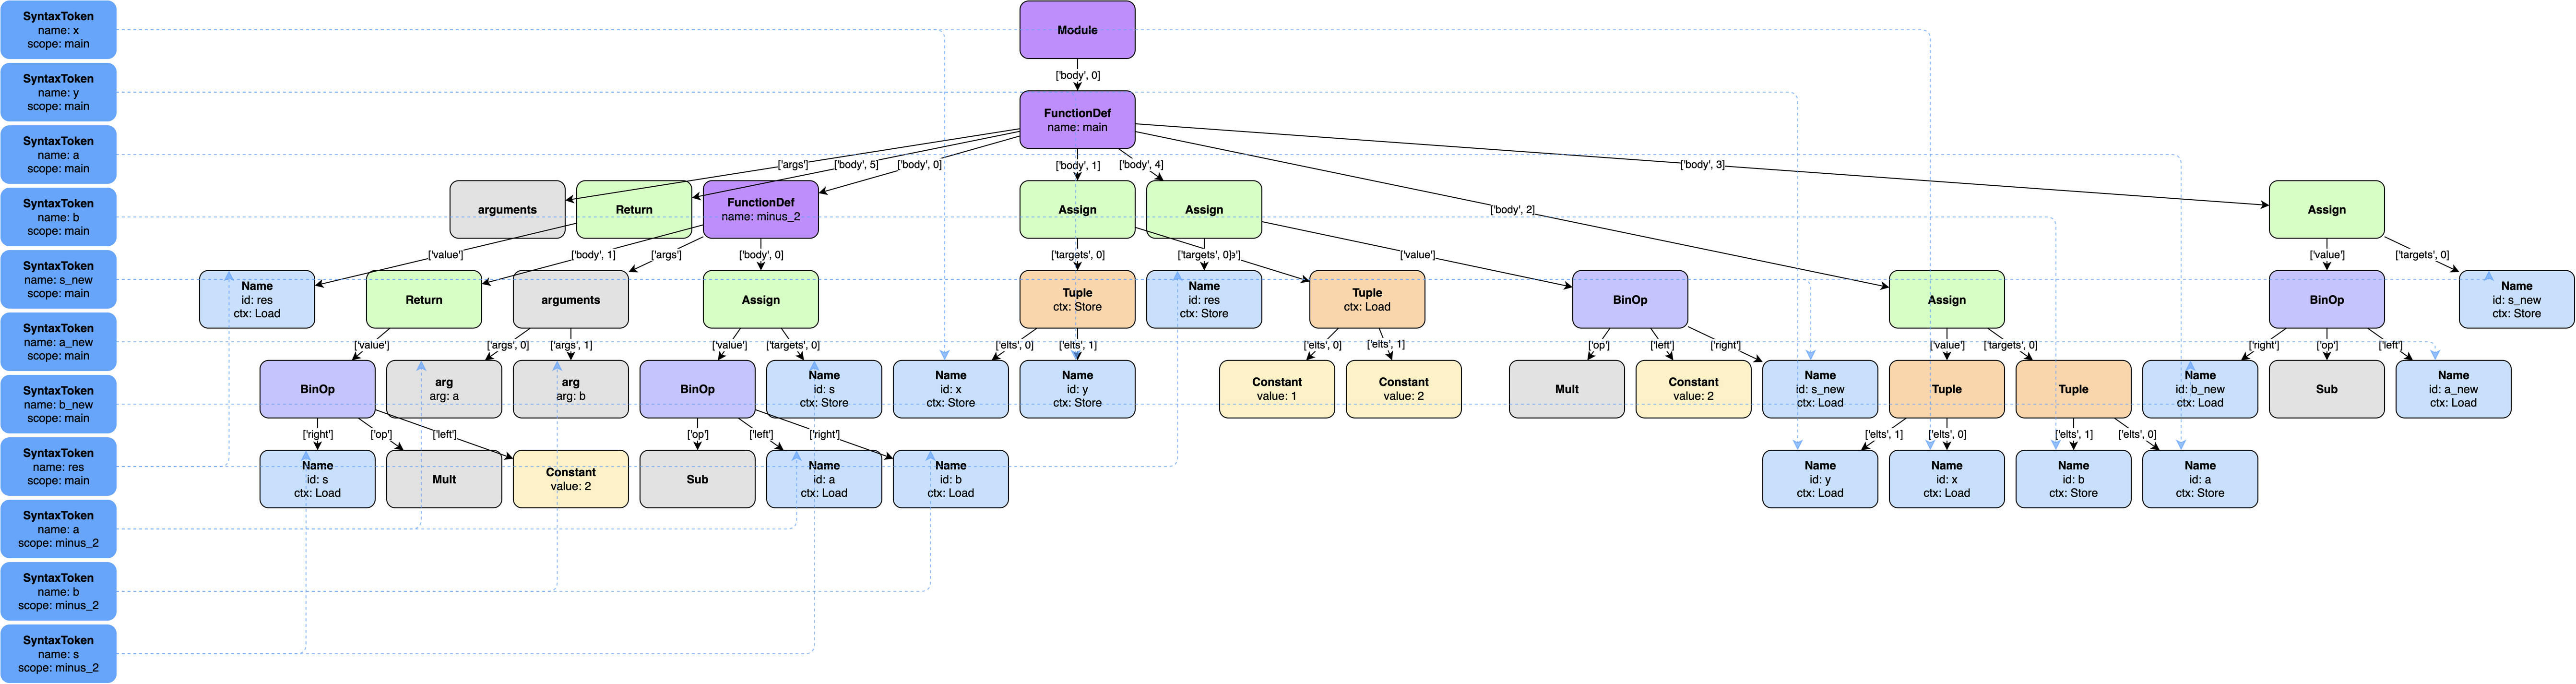

In [73]:
print('_____________')
print(G_new.to_source())


vis_drawio(G_new, 'images/test-expansion-after', params)

def main():

    def minus(a, b):
        s = a - b
        return 2 * s

    def extracted_function(minus):
        x, y = 1, 2
        res = minus(x, y)
        return res
    res = extracted_function(minus)
    return res

images/test-extraction-after.drawio -> images/test-extraction-after.png


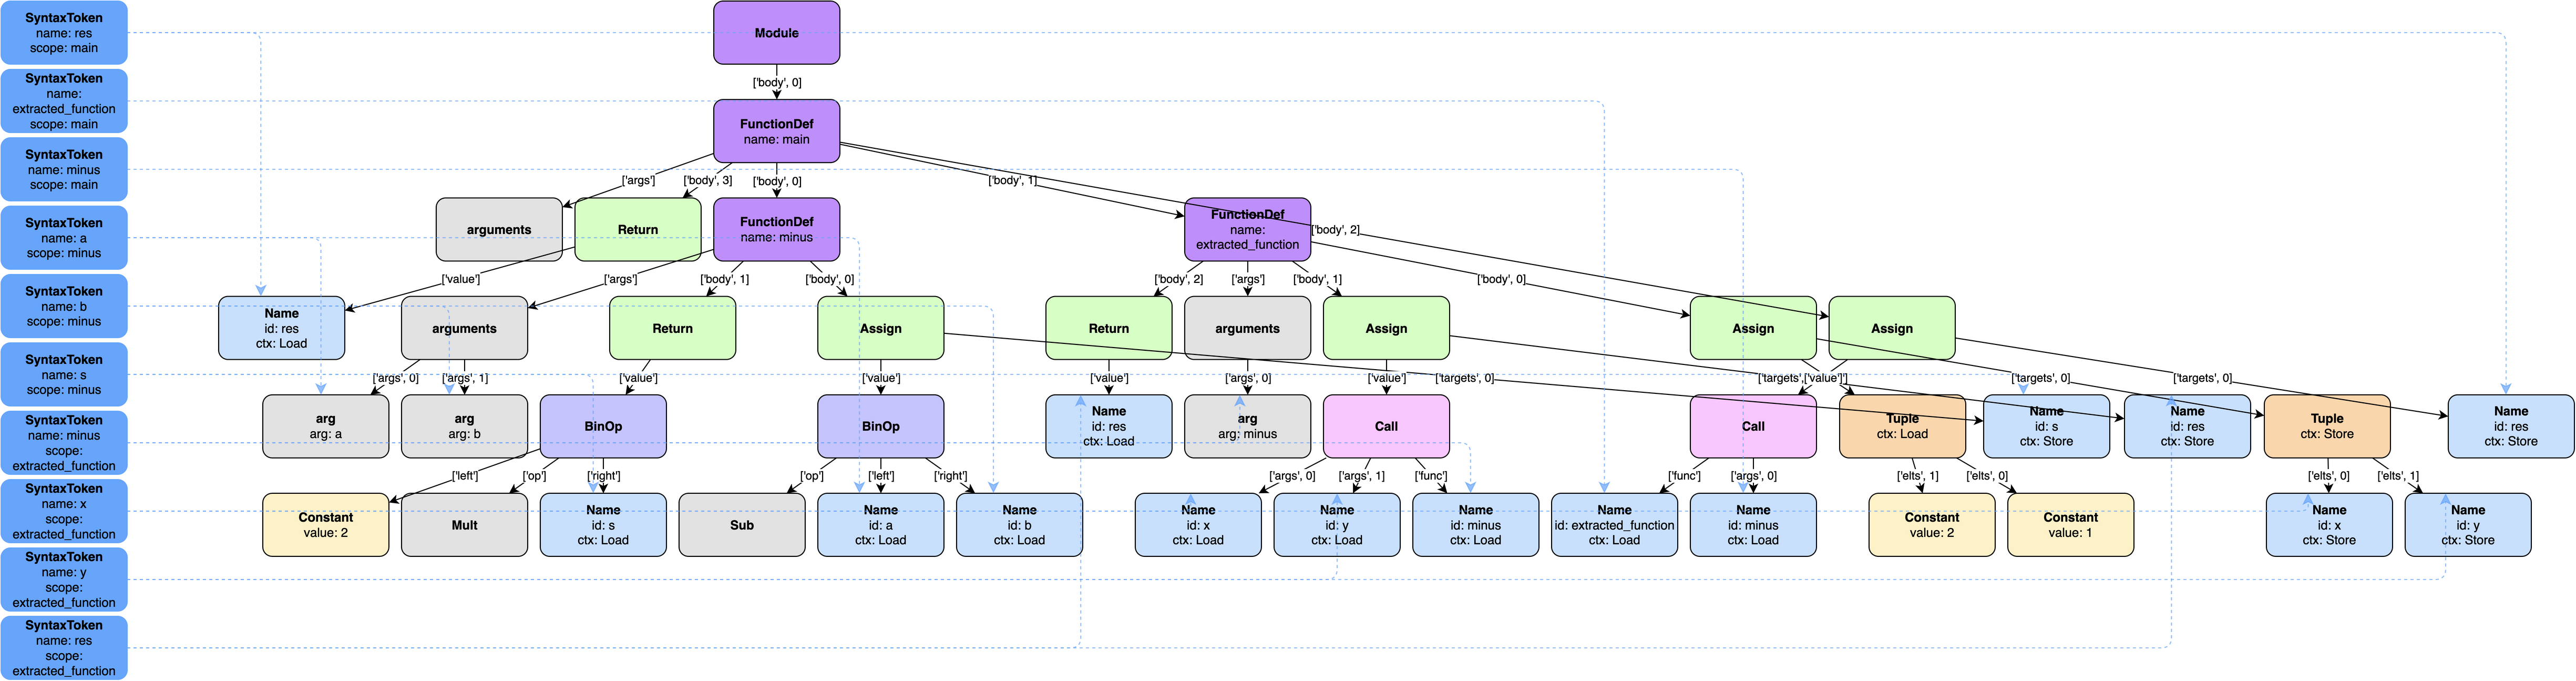

In [66]:
importlib.reload(transforms)
from transforms import extract_function
G2 = copy.deepcopy(G)
G2.refresh()

node_id = id(G2.ast_tree.body[0])
G2.ast_nodes[node_id]
G2 = extract_function(G2, node_id, 1, 2)
print(G2.to_source())
vis_drawio(G2, 'images/test-extraction-after', params)

In [37]:
G2.our_nodes[5069295904]

ASTNode(id=5069295904, name=main, args=arguments, body=[...], decorator_list=[...], returns=None, type_comment=None)

def main():
    l = [1, 2]
    l.append(3)
    return l

images/test-list.drawio -> images/test-list.png


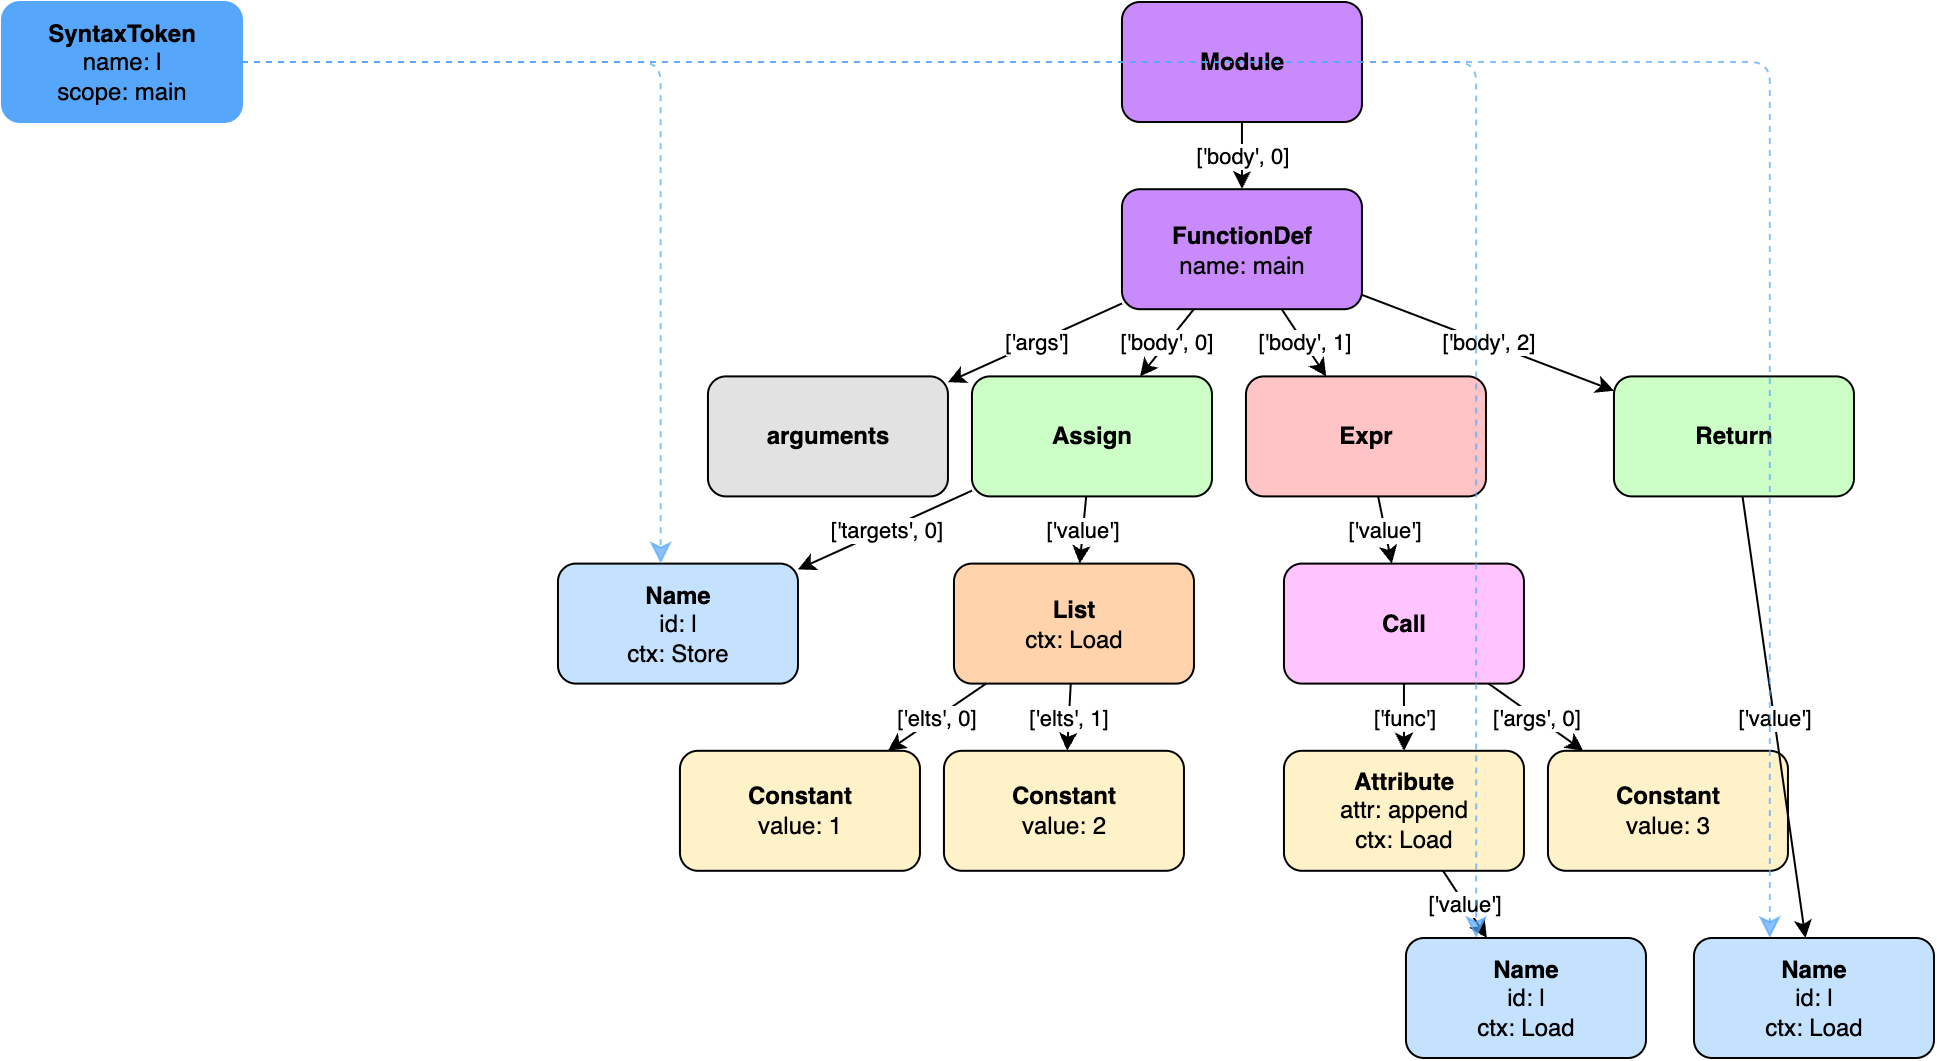

In [39]:
import transforms
importlib.reload(transforms)
from transforms import extract_function

G = CodeGraph.from_file("code_samples/test-list.py")
print(G.to_source())
vis_drawio(G, 'images/test-list', params)

In [43]:
def f(ll):
    # l = [1, 2, 3]
    l2 = ll
    l2[0] = 0
    return 0

l = [1, 2, 3]
f(l), l

(0, [0, 2, 3])